In [15]:
import numpy as np
import os

In [16]:
#cell 2

import numpy as np
import os
import json
from data_reader import load_data # Import from your corrected data_reader.py

# --- Configuration ---
JSON_FILE = 'WLASL_Cafe.json' # Your specific JSON file
LANDMARK_FOLDER = 'landmarks' # Folder containing your .npy files
MAX_SEQ_LENGTH = 100 # Adjust based on your analysis (e.g., 100 frames)
NUM_LANDMARKS = 33 # MediaPipe Pose landmarks
NUM_VALUES_PER_LANDMARK = 4 # x, y, z, visibility
OUTPUT_NPZ_FILE = 'prepared_subset_data.npz' # <<< CHANGED: Output file name for the subset data

# --- <<< MODIFICATION 1: DEFINE YOUR SUBSET OF GLOSSES >>> ---
# -----------------------------------------------------------------
# V V V V V V V  EDIT THIS LIST V V V V V V V V V V V V V V V V V V
# -----------------------------------------------------------------
# Fill this list with the exact gloss names you want to keep.
# Example: Choose glosses with > 7 available videos based on find_missing.py output
VIABLE_GLOSSES = [
    'can', 'drink', 'finish', 'go', 'help', 'hot', 'like',
    'need', 'no', 'table', 'time', 'what', 'yes', 'eat',
    # ADD MORE GLOSS NAMES HERE based on your data analysis!
    # Make sure the spelling matches the JSON file exactly.
]
# -----------------------------------------------------------------
# ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^
# -----------------------------------------------------------------
print(f"Targeting a subset of {len(VIABLE_GLOSSES)} glosses.")
# --- <<< END MODIFICATION 1 >>> ---


# --- Step 1: Load ALL Labels First ---
print(f"Loading all labels from {JSON_FILE}...")
all_instances_full = load_data(JSON_FILE)
if not all_instances_full:
    print("Error: No data loaded. Exiting.")
    exit()

# --- <<< MODIFICATION 2: FILTER INSTANCES FOR SUBSET >>> ---
print(f"Filtering instances for the {len(VIABLE_GLOSSES)} viable glosses...")
all_instances_subset = [
    inst for inst in all_instances_full if inst.get('gloss') in VIABLE_GLOSSES
]
if not all_instances_subset:
    print("Error: No instances found for the specified VIABLE_GLOSSES. Check spelling or list content. Exiting.")
    exit()
print(f"Found {len(all_instances_subset)} instances for the subset.")
# --- <<< END MODIFICATION 2 >>> ---


# --- Step 2: Create Lookup Dictionary for SUBSET ---
# Use the filtered list 'all_instances_subset' now
video_to_label_split = {}
found_ids_in_json_subset = set()
for instance in all_instances_subset: # <<< CHANGED: Use subset list
    video_id = instance.get('video_id')
    gloss = instance.get('gloss')
    split = instance.get('split')
    if video_id and gloss and split:
        video_to_label_split[video_id] = {'gloss': gloss, 'split': split}
        found_ids_in_json_subset.add(video_id)
    # No need for warning here

print(f"Created lookup dictionary for subset with {len(video_to_label_split)} entries.")


# --- Step 3: Label Encoding for SUBSET ---
print("Encoding labels for the subset...")
# Get unique glosses ONLY from the SUBSET data
subset_glosses = sorted(list(set(info['gloss'] for info in video_to_label_split.values())))
gloss_to_id = {gloss: i for i, gloss in enumerate(subset_glosses)}
id_to_gloss = {i: gloss for i, gloss in enumerate(subset_glosses)}
# <<< CHANGED: num_classes is now based on the subset >>>
num_classes = len(subset_glosses)

print(f"Found {num_classes} unique glosses in the subset.")
# print("Subset Gloss to ID mapping:", gloss_to_id) # Optional

# --- Helper Functions for Normalization and Padding ---
# (These functions remain exactly the same as before)
def normalize_landmarks(landmarks):
    """Normalizes landmarks by centering them around the nose (landmark 0)."""
    normalized_video = np.copy(landmarks)
    num_frames = landmarks.shape[0]
    num_features_per_frame = landmarks.shape[1]
    if num_features_per_frame != NUM_LANDMARKS * NUM_VALUES_PER_LANDMARK:
        print(f"  Warning: Unexpected feature count ({num_features_per_frame}). Skipping normalization.")
        return landmarks
    for frame_idx in range(num_frames):
        frame_data = landmarks[frame_idx]
        frame_reshaped = frame_data.reshape((NUM_LANDMARKS, NUM_VALUES_PER_LANDMARK))
        nose_x, nose_y = frame_reshaped[0, 0], frame_reshaped[0, 1]
        nose_visibility = frame_reshaped[0, 3]
        if nose_visibility > 0.1:
            frame_reshaped[:, 0] -= nose_x
            frame_reshaped[:, 1] -= nose_y
        else:
            frame_reshaped[:, :3] = 0.0
        normalized_video[frame_idx] = frame_reshaped.flatten()
    return normalized_video

def pad_truncate(landmarks, max_len):
    """Pads or truncates landmark sequence to a fixed length."""
    num_frames = landmarks.shape[0]
    num_features = landmarks.shape[1]
    padded_landmarks = np.zeros((max_len, num_features), dtype=np.float32)
    seq_len_to_use = min(num_frames, max_len)
    padded_landmarks[:seq_len_to_use] = landmarks[:seq_len_to_use]
    return padded_landmarks

# --- Step 4: Load SPECIFIC Landmarks, Normalize, Pad, and Split Data ---
print(f"\nProcessing subset landmark files from '{LANDMARK_FOLDER}'...")
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

processed_ids_subset = set()

# <<< CHANGED: Iterate ONLY through the video IDs relevant to our SUBSET >>>
for video_id in video_to_label_split.keys():
    landmark_file = f"{video_id}.npy"
    landmark_path = os.path.join(LANDMARK_FOLDER, landmark_file)

    # Check if the landmark file actually exists
    if os.path.exists(landmark_path):
        processed_ids_subset.add(video_id) # Track that we found the landmark file
        label_info = video_to_label_split[video_id]
        gloss = label_info['gloss']
        split = label_info['split']

        try:
            landmarks = np.load(landmark_path)
            # Basic validation checks
            if landmarks.size == 0 or landmarks.shape[0] == 0:
                 print(f"Warning: Skipping empty landmark file for {video_id} ({gloss}).")
                 continue
            if len(landmarks.shape) != 2 or landmarks.shape[1] != NUM_LANDMARKS * NUM_VALUES_PER_LANDMARK:
                 print(f"Warning: Skipping landmark file with unexpected shape {landmarks.shape} for {video_id} ({gloss}). Expected (frames, {NUM_LANDMARKS * NUM_VALUES_PER_LANDMARK})")
                 continue

            # Apply Normalization
            normalized_data = normalize_landmarks(landmarks)

            # Apply Padding/Truncation
            padded_data = pad_truncate(normalized_data, MAX_SEQ_LENGTH)

            # Get Numerical Label (using the SUBSET mapping)
            label_id = gloss_to_id[gloss]

            # Append data to the correct list based on split
            if split == 'train':
                X_train.append(padded_data)
                y_train.append(label_id)
            elif split == 'val':
                X_val.append(padded_data)
                y_val.append(label_id)
            elif split == 'test':
                X_test.append(padded_data)
                y_test.append(label_id)
            # No 'else' needed here since we pre-filtered splits

        except Exception as e:
            print(f"Error processing {landmark_file} ({gloss}): {e}")
    else:
        # This ID was in our filtered JSON but the .npy is missing
        # We already know some videos were missing earlier
        pass # print(f"Note: Landmark file {landmark_file} not found for subset video.")

# Check for videos in the SUBSET JSON that didn't have landmark files
missing_subset_landmark_ids = found_ids_in_json_subset - processed_ids_subset
if missing_subset_landmark_ids:
    print(f"\nWarning: {len(missing_subset_landmark_ids)} videos included in the viable gloss subset are missing landmark files.")
    # for missing_id in sorted(list(missing_subset_landmark_ids)):
    #     print(f" - {missing_id} ({video_to_label_split[missing_id]['gloss']})")


# Convert lists to NumPy arrays
print("\nConverting SUBSET data splits to NumPy arrays...")
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int64)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.int64)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int64)

# --- Save the SUBSET Data ---
# <<< CHANGED: Save to the new output file name >>>
print(f"\nSaving prepared SUBSET data arrays to {OUTPUT_NPZ_FILE}...")
np.savez(
    OUTPUT_NPZ_FILE,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    id_to_gloss=id_to_gloss # Save the SUBSET mapping
)
print("Subset data saved successfully.")


# --- Final Summary ---
print("\n--- SUBSET Data Preparation Complete ---")
print(f"Using MAX_SEQ_LENGTH = {MAX_SEQ_LENGTH}")
print("Train shapes:", X_train.shape, y_train.shape)
print("Val shapes:  ", X_val.shape, y_val.shape)
print("Test shapes: ", X_test.shape, y_test.shape)
print("Number of classes in subset:", num_classes) # This now reflects the subset size
print("---------------------------------------")

# (The DataLoader section remains the same conceptually but would use these new subset arrays)
# --- Step 5: Data Loaders (Example for PyTorch) ---
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# ... (rest of DataLoader code would go here in the next cell) ...

Targeting a subset of 14 glosses.
Loading all labels from WLASL_Cafe.json...
Loaded 839 video instances from WLASL_Cafe.json
Filtering instances for the 14 viable glosses...
Found 308 instances for the subset.
Created lookup dictionary for subset with 308 entries.
Encoding labels for the subset...
Found 14 unique glosses in the subset.

Processing subset landmark files from 'landmarks'...


Converting SUBSET data splits to NumPy arrays...

Saving prepared SUBSET data arrays to prepared_subset_data.npz...
Subset data saved successfully.

--- SUBSET Data Preparation Complete ---
Using MAX_SEQ_LENGTH = 100
Train shapes: (111, 100, 132) (111,)
Val shapes:   (32, 100, 132) (32,)
Test shapes:  (29, 100, 132) (29,)
Number of classes in subset: 14
---------------------------------------


In [17]:
#cell 2.1 run if above cell is not run
import numpy as np
import os
import json
from data_reader import load_data # Import from your corrected data_reader.py

# --- Configuration ---
JSON_FILE = 'WLASL_Cafe.json' # Your specific JSON file
LANDMARK_FOLDER = 'landmarks' # Folder containing your .npy files
MAX_SEQ_LENGTH = 100 # Adjust based on your analysis (e.g., 100 frames)
NUM_LANDMARKS = 33 # MediaPipe Pose landmarks
NUM_VALUES_PER_LANDMARK = 4 # x, y, z, visibility

# --- Step 1 & 2: Load Labels and Create Lookup Dictionary ---
print(f"Loading labels from {JSON_FILE}...")
all_instances = load_data(JSON_FILE)
if not all_instances:
    print("Error: No data loaded. Exiting.")
    exit()

video_to_label_split = {}
found_ids_in_json = set()
for instance in all_instances:
    video_id = instance.get('video_id')
    gloss = instance.get('gloss')
    split = instance.get('split')
    if video_id and gloss and split: # Ensure essential info exists
        video_to_label_split[video_id] = {'gloss': gloss, 'split': split}
        found_ids_in_json.add(video_id)
    else:
        print(f"Warning: Skipping instance due to missing data: {instance}")

print(f"Created lookup dictionary with {len(video_to_label_split)} entries.")

# --- Step 3: Label Encoding ---
print("Encoding labels...")
all_glosses = sorted(list(set(info['gloss'] for info in video_to_label_split.values())))
gloss_to_id = {gloss: i for i, gloss in enumerate(all_glosses)}
id_to_gloss = {i: gloss for i, gloss in enumerate(all_glosses)}
num_classes = len(all_glosses)

print(f"Found {num_classes} unique glosses.")
# print("Gloss to ID mapping:", gloss_to_id) # Optional: print the mapping

# --- Helper Functions for Normalization and Padding ---

def normalize_landmarks(landmarks):
    """Normalizes landmarks by centering them around the nose (landmark 0)."""
    normalized_video = np.copy(landmarks) # Work on a copy
    num_frames = landmarks.shape[0]
    num_features_per_frame = landmarks.shape[1]

    if num_features_per_frame != NUM_LANDMARKS * NUM_VALUES_PER_LANDMARK:
         print(f"  Warning: Unexpected number of features ({num_features_per_frame}). Expected {NUM_LANDMARKS * NUM_VALUES_PER_LANDMARK}. Skipping normalization for this video.")
         return landmarks # Return original if shape is wrong

    for frame_idx in range(num_frames):
        frame_data = landmarks[frame_idx]
        frame_reshaped = frame_data.reshape((NUM_LANDMARKS, NUM_VALUES_PER_LANDMARK))

        nose_x, nose_y = frame_reshaped[0, 0], frame_reshaped[0, 1]
        nose_visibility = frame_reshaped[0, 3]

        # Only normalize if nose is reasonably visible
        if nose_visibility > 0.1:
            frame_reshaped[:, 0] -= nose_x # Center x coordinates
            frame_reshaped[:, 1] -= nose_y # Center y coordinates
            # We don't typically center Z as it represents depth relative to hip
        else:
            # If nose is not visible, zero out spatial coords (x, y, z) for safety
            frame_reshaped[:, :3] = 0.0

        normalized_video[frame_idx] = frame_reshaped.flatten()

    return normalized_video

def pad_truncate(landmarks, max_len):
    """Pads or truncates landmark sequence to a fixed length."""
    num_frames = landmarks.shape[0]
    num_features = landmarks.shape[1]
    padded_landmarks = np.zeros((max_len, num_features), dtype=np.float32)

    if num_frames >= max_len:
        # Truncate (take the first max_len frames)
        padded_landmarks = landmarks[:max_len]
    else:
        # Pad (place existing frames at the beginning)
        padded_landmarks[:num_frames] = landmarks

    return padded_landmarks

# --- Step 4: Load Landmarks, Normalize, Pad, and Split Data ---
print(f"\nProcessing landmark files from '{LANDMARK_FOLDER}'...")
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

landmark_files = os.listdir(LANDMARK_FOLDER)
processed_ids = set()

for landmark_file in landmark_files:
    if not landmark_file.endswith('.npy'):
        continue

    video_id = os.path.splitext(landmark_file)[0]
    processed_ids.add(video_id) # Track which landmarks were found

    if video_id in video_to_label_split:
        label_info = video_to_label_split[video_id]
        gloss = label_info['gloss']
        split = label_info['split']

        landmark_path = os.path.join(LANDMARK_FOLDER, landmark_file)
        try:
            landmarks = np.load(landmark_path)

            # Check for empty files resulted from previous errors
            if landmarks.size == 0 or landmarks.shape[0] == 0:
                 print(f"Warning: Skipping empty landmark file for {video_id} ({gloss}).")
                 continue
            if len(landmarks.shape) != 2:
                 print(f"Warning: Skipping landmark file with unexpected shape {landmarks.shape} for {video_id} ({gloss}).")
                 continue


            # Apply Normalization
            normalized_data = normalize_landmarks(landmarks)

            # Apply Padding/Truncation
            padded_data = pad_truncate(normalized_data, MAX_SEQ_LENGTH)

            # Get Numerical Label
            label_id = gloss_to_id[gloss]

            # Append data to the correct list based on split
            if split == 'train':
                X_train.append(padded_data)
                y_train.append(label_id)
            elif split == 'val':
                X_val.append(padded_data)
                y_val.append(label_id)
            elif split == 'test':
                X_test.append(padded_data)
                y_test.append(label_id)
            else:
                 print(f"Warning: Unknown split value '{split}' for video {video_id}. Skipping.")

        except FileNotFoundError:
             print(f"Warning: Landmark file {landmark_file} not found, though expected. Skipping.")
        except Exception as e:
            print(f"Error processing {landmark_file} ({gloss}): {e}")

    else:
        # This case should ideally not happen if landmarks were generated from videos listed in the JSON
        print(f"Warning: Landmark file found for video ID {video_id}, but this ID is not in {JSON_FILE}. Skipping.")

# Check for videos listed in JSON but missing landmark files
missing_landmark_ids = found_ids_in_json - processed_ids
if missing_landmark_ids:
    print("\nWarning: Some videos listed in the JSON do not have corresponding landmark files:")
    # for missing_id in sorted(list(missing_landmark_ids)):
    #     print(f" - {missing_id} ({video_to_label_split[missing_id]['gloss']})") # Optionally print details
    print(f"Total missing landmark files: {len(missing_landmark_ids)}")


# Convert lists to NumPy arrays
print("\nConverting data splits to NumPy arrays...")
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int64) # Use int64 for labels/indices
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.int64)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int64)

print("\n--- Data Preparation Complete ---")
print(f"Using MAX_SEQ_LENGTH = {MAX_SEQ_LENGTH}")
print("Train shapes:", X_train.shape, y_train.shape)
print("Val shapes:  ", X_val.shape, y_val.shape)
print("Test shapes: ", X_test.shape, y_test.shape)
print("Number of classes:", num_classes)
print("---------------------------------")

# --- ADD THIS SAVING STEP ---
print(f"\nSaving prepared data arrays to prepared_data.npz...")
np.savez(
    'prepared_data.npz', 
    X_train=X_train, 
    y_train=y_train, 
    X_val=X_val, 
    y_val=y_val, 
    X_test=X_test, 
    y_test=y_test,
    id_to_gloss=id_to_gloss # Save the mapping too
)
print("Data saved successfully.")
# --- END OF SAVING STEP --

# --- Step 5: Data Loaders (Example for PyTorch) ---
# You would typically put this section in your training script

# import torch
# from torch.utils.data import TensorDataset, DataLoader

# BATCH_SIZE = 32 # Example batch size

# # Create TensorDatasets
# train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
# val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
# test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# # Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# print("\nPyTorch DataLoaders created (example).")
# # Now you can iterate through train_loader etc. in your training loop

Loading labels from WLASL_Cafe.json...
Loaded 839 video instances from WLASL_Cafe.json
Created lookup dictionary with 839 entries.
Encoding labels...
Found 50 unique glosses.

Processing landmark files from 'landmarks'...

Total missing landmark files: 548

Converting data splits to NumPy arrays...

--- Data Preparation Complete ---
Using MAX_SEQ_LENGTH = 100
Train shapes: (186, 100, 132) (186,)
Val shapes:   (58, 100, 132) (58,)
Test shapes:  (47, 100, 132) (47,)
Number of classes: 50
---------------------------------

Saving prepared data arrays to prepared_data.npz...
Data saved successfully.


In [18]:
#cell 1
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math
import os # Make sure os is imported if loading files here

# --- Configuration ---
NUM_CLASSES = 14       # You found 50 unique glosses
MAX_SEQ_LENGTH = 100   # Must match the padding length used in prepare_data.py
INPUT_FEATURES = 132   # 33 landmarks * 4 values (x, y, z, vis)

# Model Hyperparameters (Adjust as needed)
EMBED_DIM = 256        # Dimension to project landmarks into
NUM_HEADS = 8          # Number of attention heads in Transformer
NUM_ENCODER_LAYERS = 3 # Number of Transformer Encoder layers
DIM_FEEDFORWARD = 512  # Hidden dimension in Transformer's FFN
DROPOUT = 0.2

# Training Hyperparameters
LEARNING_RATE = 0.0001
BATCH_SIZE = 16 # Adjust based on your GPU memory
EPOCHS = 50     # Start with a moderate number, increase if needed

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [19]:
#cell 2
# Option 1: If arrays are already in memory from a previous cell
# print("Using data arrays from previous cell.")
# print("Train shapes:", X_train.shape, y_train.shape)
# print("Val shapes:", X_val.shape, y_val.shape)
# print("Test shapes:", X_test.shape, y_test.shape)

# Option 2: If you saved the arrays to a file (e.g., 'prepared_data.npz')
# Ensure you saved them using np.savez in prepare_data.py like:
# np.savez('prepared_data.npz', X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, id_to_gloss=id_to_gloss)

data_file = 'prepared_subset_data.npz'
#data_file = 'prepared_data.npz' # Make sure you created this file

if os.path.exists(data_file):
    print(f"Loading prepared data from {data_file}...")
    data = np.load(data_file, allow_pickle=True) # allow_pickle needed for id_to_gloss dict
    X_train = data['X_train']
    y_train = data['y_train']
    X_val = data['X_val']
    y_val = data['y_val']
    X_test = data['X_test']
    y_test = data['y_test']
    # Load the id_to_gloss mapping if you saved it
    # id_to_gloss = data['id_to_gloss'].item() # .item() retrieves the dict
    print("Data loaded successfully.")
    print("Train shapes:", X_train.shape, y_train.shape)
    print("Val shapes:", X_val.shape, y_val.shape)
    print("Test shapes:", X_test.shape, y_test.shape)
else:
    print(f"Error: {data_file} not found. Please run prepare_data.py or ensure the file is in the correct directory.")
    # Stop execution or handle appropriately if data isn't loaded
    raise FileNotFoundError(f"{data_file} not found.")

# Convert NumPy arrays to PyTorch Tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long() # Use long for class indices
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

Loading prepared data from prepared_subset_data.npz...
Data loaded successfully.
Train shapes: (111, 100, 132) (111,)
Val shapes: (32, 100, 132) (32,)
Test shapes: (29, 100, 132) (29,)


In [20]:
#cell 3
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created.")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

DataLoaders created.
Batch size: 16
Number of training batches: 7
Number of validation batches: 2
Number of test batches: 2


In [21]:
#cell 4
class PositionalEncoding(nn.Module):
    """Adds positional information to the input sequence embeddings."""
    def __init__(self, d_model, dropout=0.2, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe) # Makes 'pe' part of the model state but not a parameter

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

print("PositionalEncoding class defined.")

PositionalEncoding class defined.


In [22]:
#cell 5
class PoseTransformer(nn.Module):
    """Transformer model for pose sequence classification."""
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dim_feedforward, num_classes, max_seq_len, dropout=0.2):
        super(PoseTransformer, self).__init__()
        self.embed_dim = embed_dim
        
        # Input embedding layer (Linear layer to project input features)
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(embed_dim, dropout, max_len=max_seq_len)
        
        # Standard PyTorch Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, 
                                                   batch_first=False) # Important: PyTorch default expects (Seq, Batch, Feature)
        encoder_norm = nn.LayerNorm(embed_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, norm=encoder_norm)
        
        # Classification head
        self.fc_out = nn.Linear(embed_dim, num_classes)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.input_embedding.weight.data.uniform_(-initrange, initrange)
        self.input_embedding.bias.data.zero_()
        self.fc_out.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()

    def forward(self, src):
        """
        Args:
            src: Tensor, shape [batch_size, seq_len, input_dim]
        """
        # --- Reshape for PyTorch Transformer ---
        # Input shape: (Batch, Seq, Feature) -> (Seq, Batch, Feature)
        src = src.transpose(0, 1) 
        
        # --- Processing ---
        src = self.input_embedding(src) * math.sqrt(self.embed_dim) # Embed input
        src = self.pos_encoder(src) # Add positional encoding
        output = self.transformer_encoder(src) # Pass through Transformer Encoder
        
        # --- Classification ---
        # Use the output corresponding to the first token ([CLS] token analogy) 
        # or average pooling over the sequence. Here we use the first token's output.
        output = output[0, :, :] # Take output of the first time step -> Shape: (Batch, Feature)
        # Alternatively, mean pooling: output = output.mean(dim=0) # Shape: (Batch, Feature)

        output = self.fc_out(output) # Final classification layer
        return output # Logits output, CrossEntropyLoss applies softmax internally

print("PoseTransformer class defined.")

PoseTransformer class defined.


In [23]:
#cell 6
# Instantiate the model
model = PoseTransformer(
    input_dim=INPUT_FEATURES,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_ENCODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    num_classes=NUM_CLASSES,
    max_seq_len=MAX_SEQ_LENGTH,
    dropout=DROPOUT
).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
# In Cell 6, modify the optimizer:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # Add weight_decay

print("Model, Criterion (Loss), and Optimizer initialized.")
print(f"Model moved to device: {device}")

# Optional: Print model summary (requires torchinfo library: pip install torchinfo)
# from torchinfo import summary
# summary(model, input_size=(BATCH_SIZE, MAX_SEQ_LENGTH, INPUT_FEATURES))

Model, Criterion (Loss), and Optimizer initialized.
Model moved to device: cpu


C:\Users\hp\OneDrive\Desktop\major project 2\WLASL\TrainEnvironment\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [24]:
#cell 7
print("Starting training...")

# Store metrics for plotting later (optional)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (sequences, labels) in enumerate(train_loader):
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad(): # No gradients needed for validation
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Epoch [{epoch+1}/{EPOCHS}] | '
          f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | '
          f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%')

print("\nTraining Finished!")

Starting training...
Epoch [1/50] | Train Loss: 2.7703 | Train Acc: 11.71% | Val Loss: 2.6384 | Val Acc: 12.50%
Epoch [2/50] | Train Loss: 2.6666 | Train Acc: 8.11% | Val Loss: 2.5783 | Val Acc: 12.50%
Epoch [3/50] | Train Loss: 2.5517 | Train Acc: 13.51% | Val Loss: 2.5352 | Val Acc: 15.62%
Epoch [4/50] | Train Loss: 2.5818 | Train Acc: 10.81% | Val Loss: 2.5787 | Val Acc: 15.62%
Epoch [5/50] | Train Loss: 2.4848 | Train Acc: 16.22% | Val Loss: 2.6006 | Val Acc: 12.50%
Epoch [6/50] | Train Loss: 2.4632 | Train Acc: 11.71% | Val Loss: 2.5671 | Val Acc: 15.62%
Epoch [7/50] | Train Loss: 2.3976 | Train Acc: 16.22% | Val Loss: 2.5085 | Val Acc: 9.38%
Epoch [8/50] | Train Loss: 2.3601 | Train Acc: 16.22% | Val Loss: 2.5340 | Val Acc: 18.75%
Epoch [9/50] | Train Loss: 2.3081 | Train Acc: 17.12% | Val Loss: 2.5065 | Val Acc: 15.62%
Epoch [10/50] | Train Loss: 2.3080 | Train Acc: 18.02% | Val Loss: 2.5293 | Val Acc: 18.75%
Epoch [11/50] | Train Loss: 2.2040 | Train Acc: 22.52% | Val Loss: 2.4

In [25]:
# cell 8
print("\nEvaluating on Training Set...")
model.eval() # Set model to evaluation mode
correct_train_final = 0
total_train_final = 0

with torch.no_grad(): # No gradients needed
    # Use train_loader here
    for sequences, labels in train_loader: 
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total_train_final += labels.size(0)
        correct_train_final += (predicted == labels).sum().item()

train_accuracy_final = 100 * correct_train_final / total_train_final
print(f'Final Accuracy on the Training Set: {train_accuracy_final:.2f}%')


Evaluating on Training Set...
Final Accuracy on the Training Set: 76.58%


In [26]:
print("\nEvaluating on Test Set...")
model.eval() # Set model to evaluation mode
correct_test = 0
total_test = 0

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Accuracy on the Test Set: {test_accuracy:.2f}%')


Evaluating on Test Set...
Accuracy on the Test Set: 37.93%



Evaluating model on the TRAINING Set...

Overall Accuracy on the TRAINING Set: 76.58% (85/111)

Accuracy per class (Training Set):
  - again: 87.50% (7/8)
  - bathroom: 92.31% (12/13)
  - big: 50.00% (3/6)
  - cake: 62.50% (5/8)
  - can: 72.73% (8/11)
  - chocolate: 71.43% (5/7)
  - coffee: 90.00% (9/10)
  - cold: 90.91% (10/11)
  - cookie: 66.67% (2/3)
  - drink: 40.00% (4/10)
  - eat: 100.00% (5/5)
  - finish: 66.67% (2/3)
  - food: 100.00% (6/6)
  - go: 70.00% (7/10)

Generating Confusion Matrix (Training Set)...


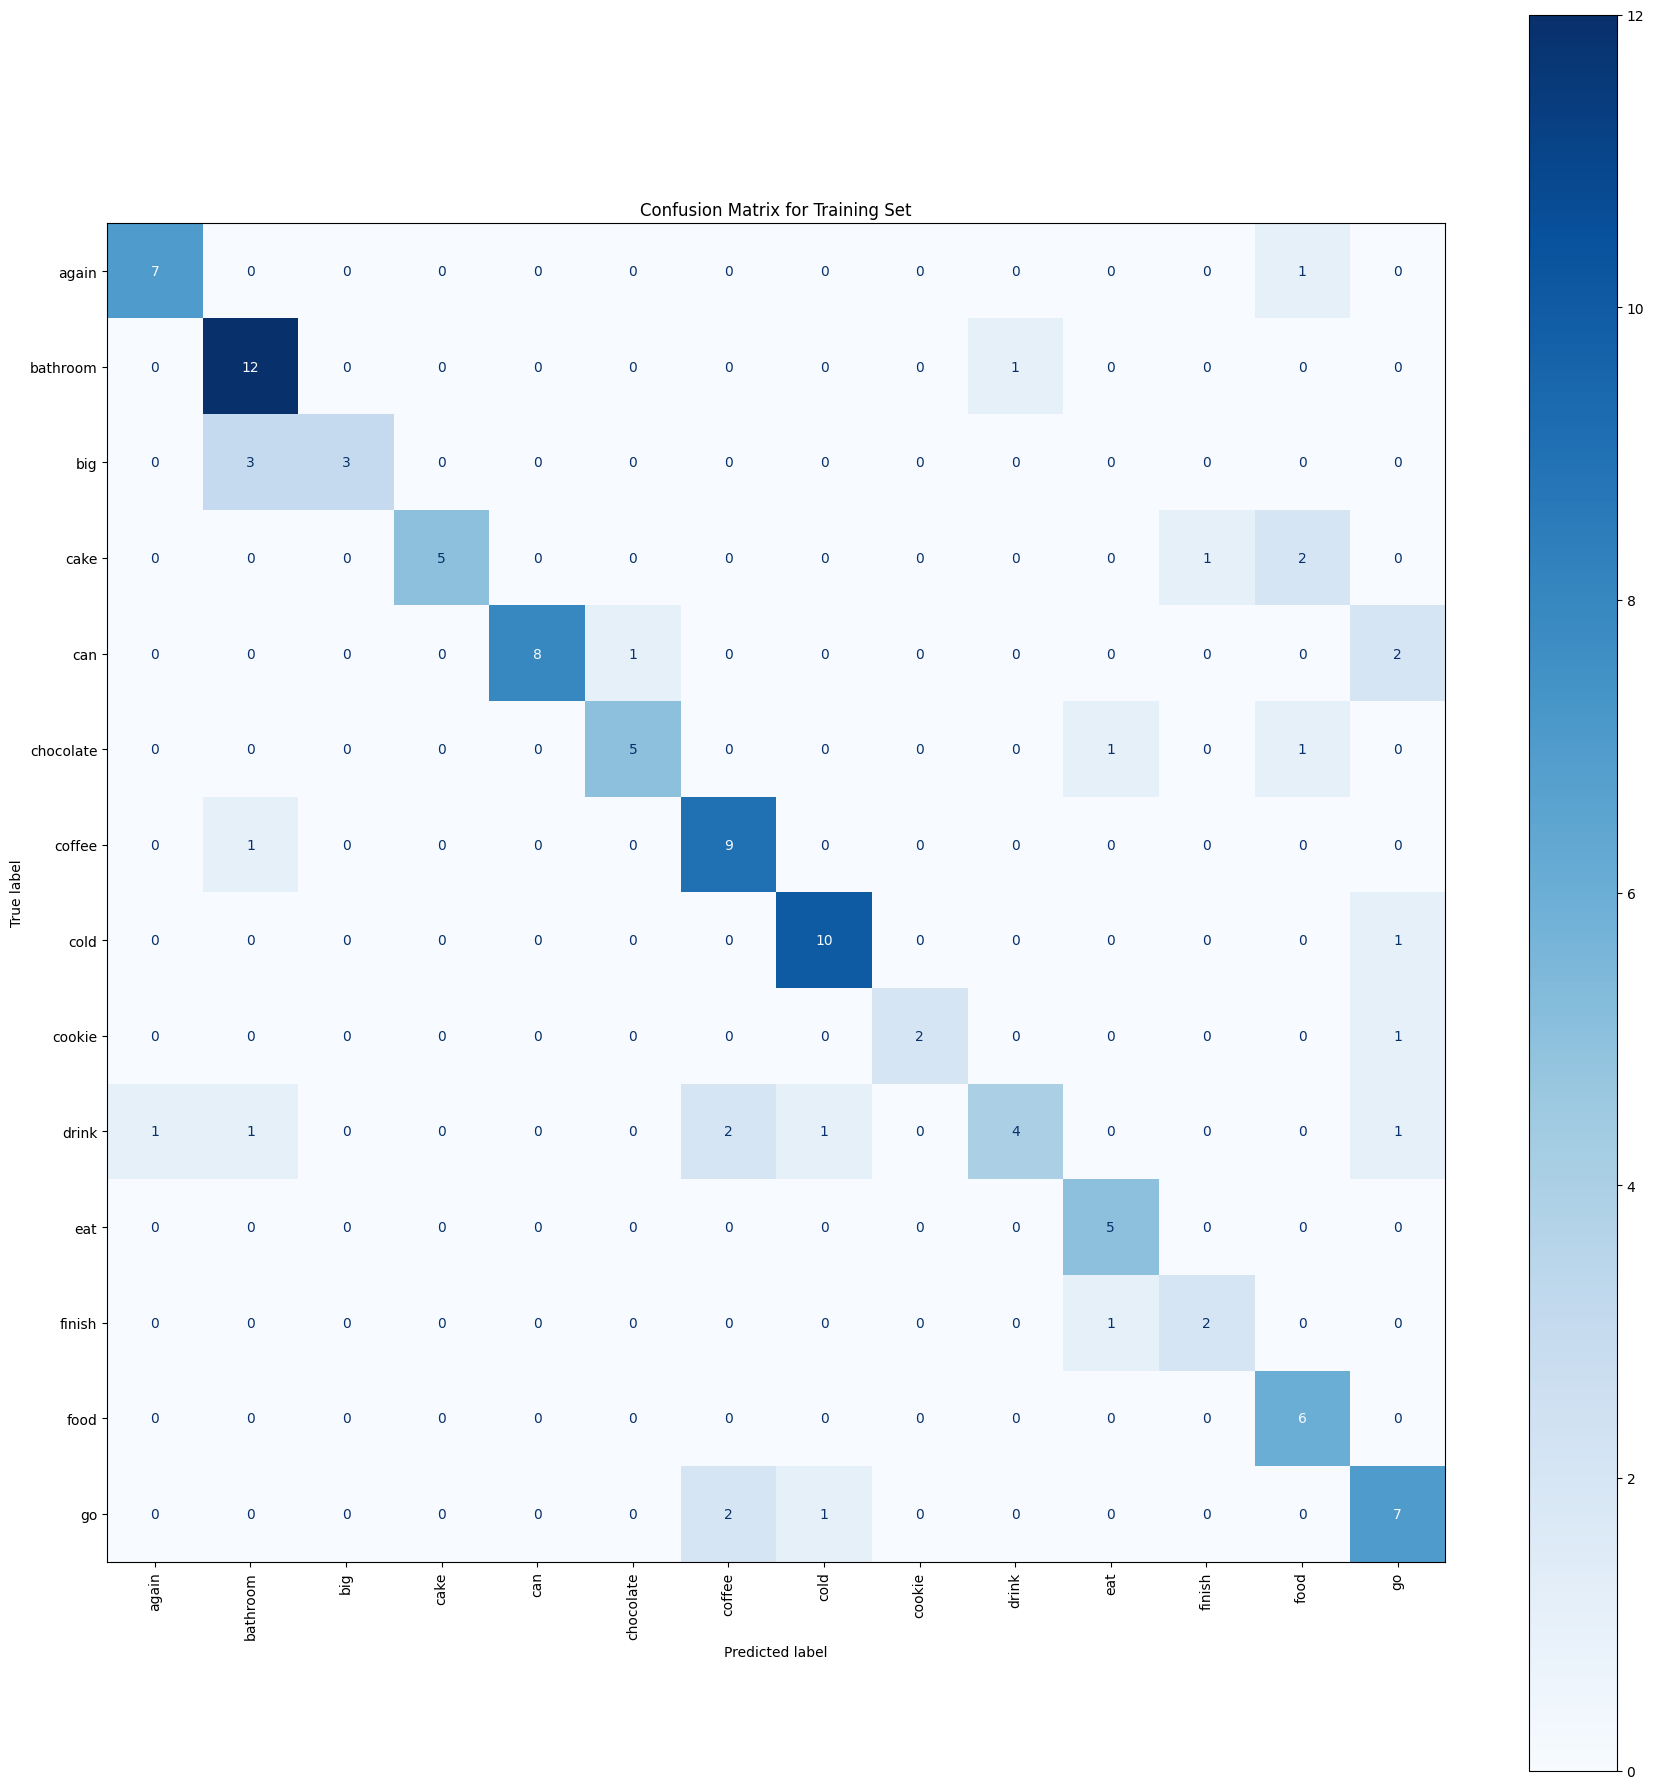

In [27]:


# --- Ensure id_to_gloss mapping exists ---
# (Assuming it was loaded correctly in the previous evaluation cell or Cell 2)
if 'id_to_gloss' not in locals() or not isinstance(id_to_gloss, dict):
    print("Error: id_to_gloss mapping not found or is not a dictionary. Please ensure it's loaded correctly.")
    # You might need to add the loading code from the previous cell here if running independently
    # For now, create a dummy one to avoid errors if needed for plotting
    id_to_gloss = {i: f"Class_{i}" for i in range(NUM_CLASSES)}

print("\nEvaluating model on the TRAINING Set...") # <-- Changed Title
model.eval() # Set model to evaluation mode

# Initialize lists/arrays for storing metrics
train_class_correct = list(0. for i in range(NUM_CLASSES)) # <-- Changed Variable Name
train_class_total = list(0. for i in range(NUM_CLASSES))   # <-- Changed Variable Name
train_all_preds = []                                       # <-- Changed Variable Name
train_all_labels = []                                      # <-- Changed Variable Name

with torch.no_grad():
    # --- CHANGED: Iterate through train_loader ---
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and labels
        train_all_preds.extend(predicted.cpu().numpy())    # <-- Changed Variable Name
        train_all_labels.extend(labels.cpu().numpy())      # <-- Changed Variable Name

        correct_predictions = (predicted == labels).squeeze()

        # Update per-class counts
        if labels.size(0) == 1:
             label_index = labels[0].item()
             train_class_correct[label_index] += correct_predictions.item() # <-- Changed Variable Name
             train_class_total[label_index] += 1                           # <-- Changed Variable Name
        else:
            for i in range(labels.size(0)):
                label_index = labels[i].item()
                train_class_correct[label_index] += correct_predictions[i].item() # <-- Changed Variable Name
                train_class_total[label_index] += 1                           # <-- Changed Variable Name

# --- Calculate and Print Overall TRAINING Accuracy ---
total_train_correct_predictions = sum(train_class_correct) # <-- Changed Variable Name
total_train_samples = sum(train_class_total)             # <-- Changed Variable Name

if total_train_samples > 0:
    overall_train_accuracy = 100 * total_train_correct_predictions / total_train_samples # <-- Changed Variable Name
    # <-- Changed Print Statement -->
    print(f'\nOverall Accuracy on the TRAINING Set: {overall_train_accuracy:.2f}% ({int(total_train_correct_predictions)}/{int(total_train_samples)})')
else:
    print("\nError: No samples found in the training set to evaluate.")

# --- Calculate and Print Per-Class TRAINING Accuracy ---
print("\nAccuracy per class (Training Set):") # <-- Changed Title
for i in range(NUM_CLASSES):
    gloss_name = id_to_gloss.get(i, f"Unknown Class {i}")
    # <-- Use train_class_total and train_class_correct -->
    if train_class_total[i] > 0:
        accuracy = 100 * train_class_correct[i] / train_class_total[i]
        print(f'  - {gloss_name}: {accuracy:.2f}% ({int(train_class_correct[i])}/{int(train_class_total[i])})')
    else:
        # Should not happen for training set unless a class was completely missing
        print(f'  - {gloss_name}: N/A (0 samples in training set)')


# --- Optional: Display Confusion Matrix for TRAINING Set ---
print("\nGenerating Confusion Matrix (Training Set)...") # <-- Changed Title
# <-- Use train_all_labels and train_all_preds -->
if train_all_labels and train_all_preds:
    try:
        cm_train = confusion_matrix(train_all_labels, train_all_preds, labels=range(NUM_CLASSES)) # <-- Changed Variable Name
        display_labels = [id_to_gloss.get(i, f"Class_{i}") for i in range(NUM_CLASSES)]

        fig_train, ax_train = plt.subplots(figsize=(18, 18)) # <-- Changed Variable Names

        disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels) # <-- Changed Variable Name
        disp_train.plot(cmap=plt.cm.Blues, ax=ax_train, xticks_rotation='vertical', values_format='d') # <-- Changed Variable Names

        plt.title("Confusion Matrix for Training Set") # <-- Changed Title
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("\nCould not generate confusion matrix.")
        print("Please install scikit-learn and matplotlib:")
        print("  pip install scikit-learn matplotlib")
    except Exception as e:
        print(f"\nAn error occurred while generating the training confusion matrix: {e}")
else:
    print("Skipping training confusion matrix: No predictions or labels available.")


Evaluating model on the Test Set...

Overall Accuracy on the Test Set: 37.93% (11/29)

Accuracy per class:
  - again: 0.00% (0/1)
  - bathroom: 100.00% (2/2)
  - big: 0.00% (0/1)
  - cake: 33.33% (1/3)
  - can: 50.00% (1/2)
  - chocolate: 33.33% (1/3)
  - coffee: 100.00% (3/3)
  - cold: 0.00% (0/2)
  - cookie: 0.00% (0/2)
  - drink: 0.00% (0/1)
  - eat: 50.00% (1/2)
  - finish: 0.00% (0/2)
  - food: 50.00% (1/2)
  - go: 33.33% (1/3)

Generating Confusion Matrix...


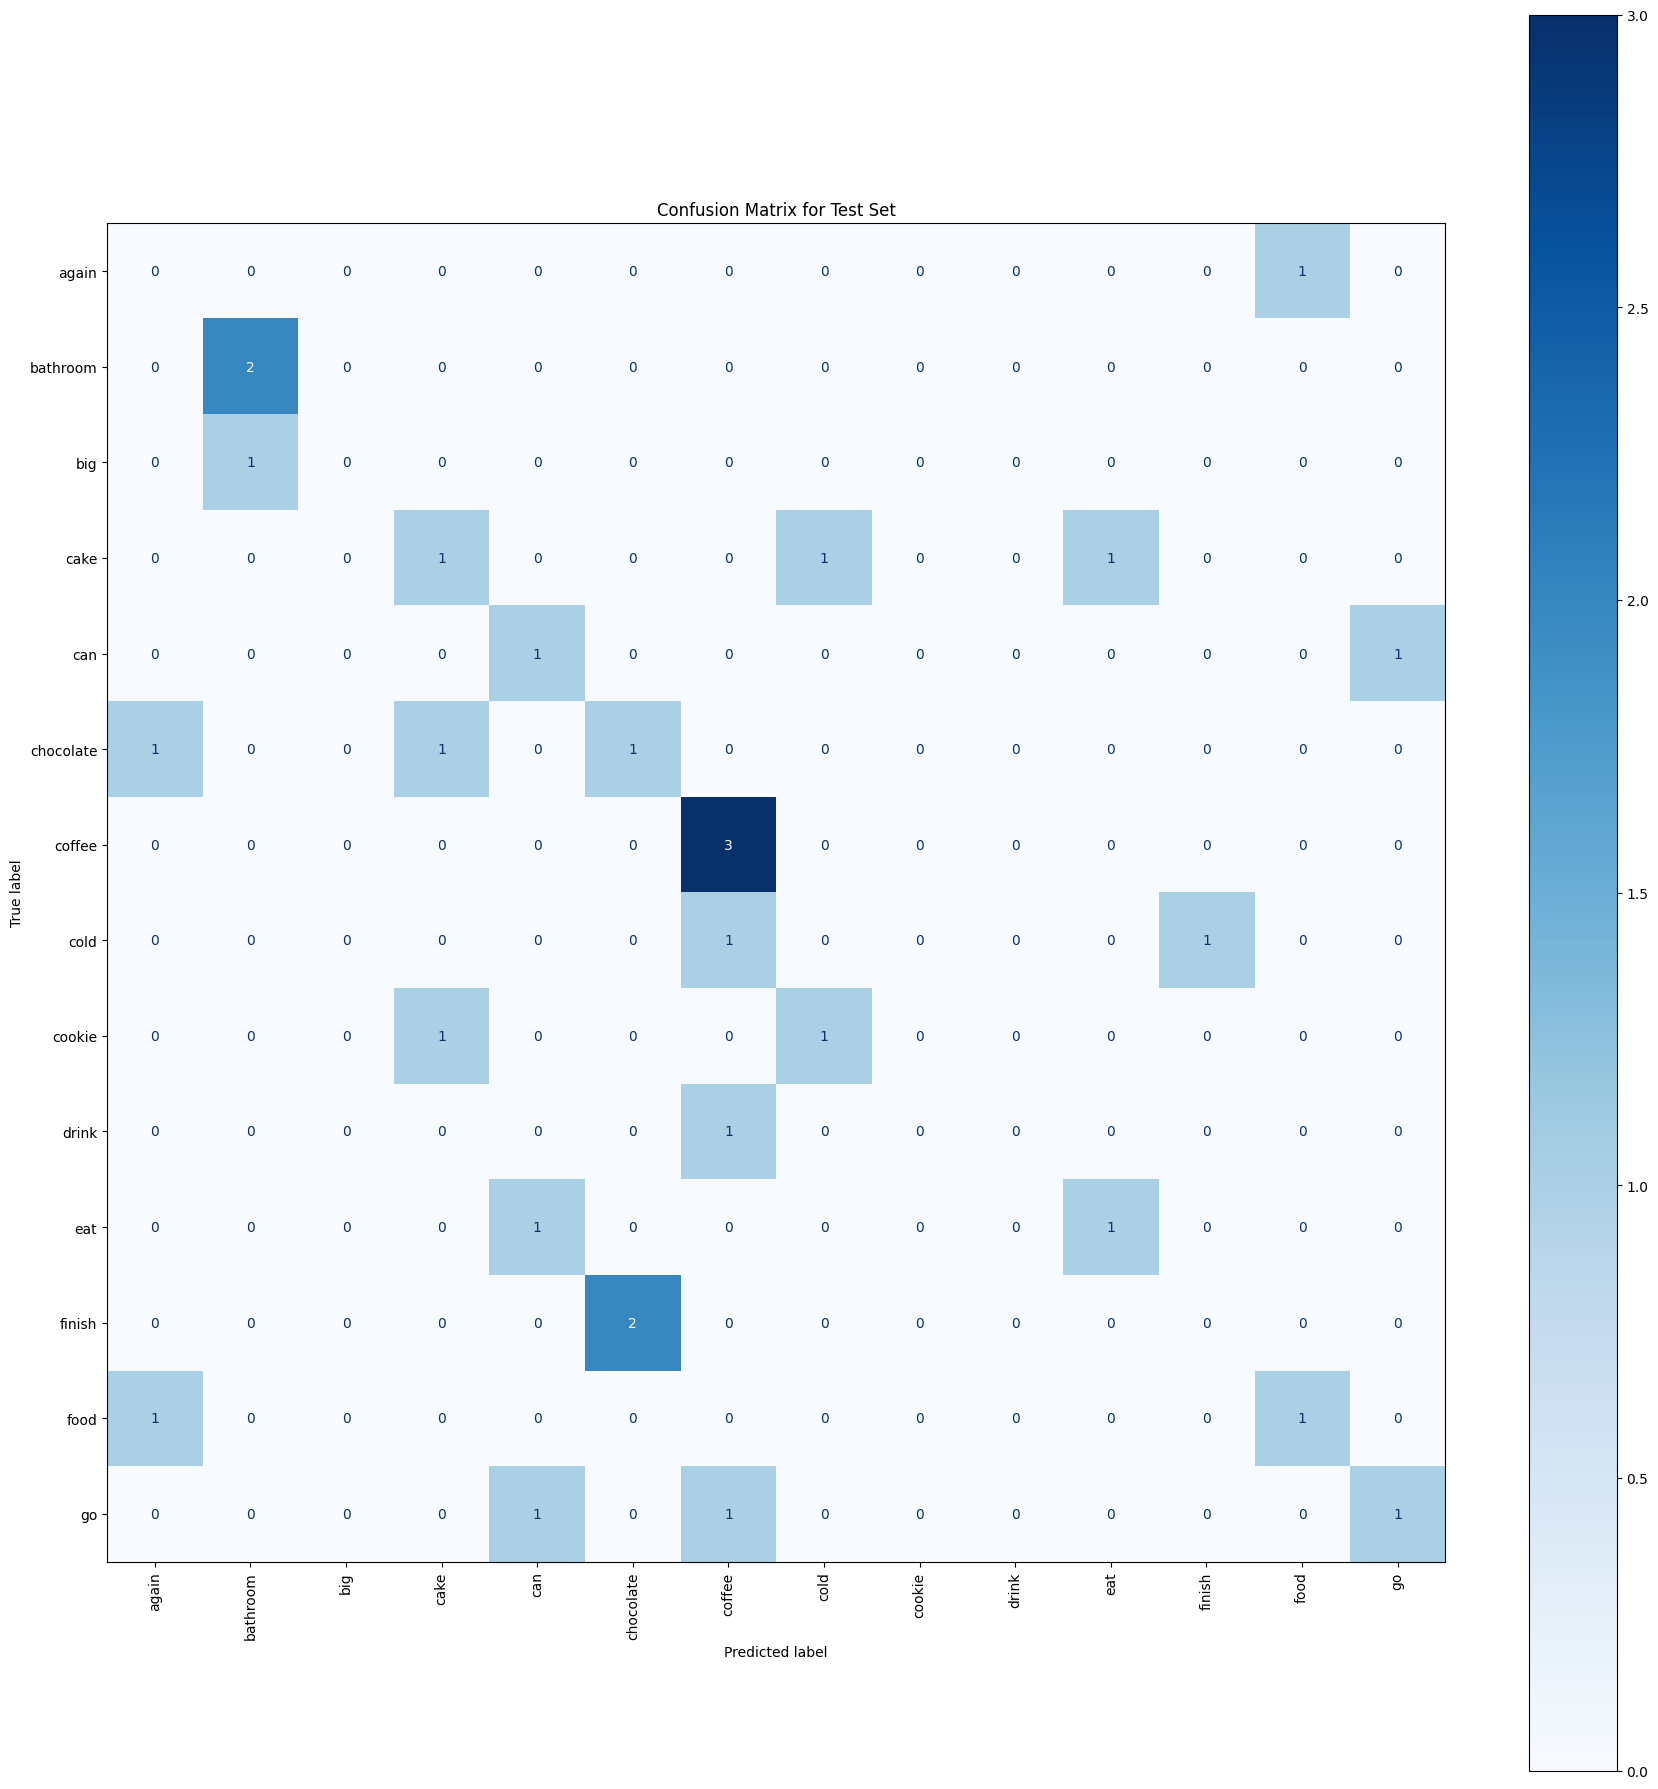

In [28]:

# Make sure scikit-learn and matplotlib are installed for the optional confusion matrix
# pip install scikit-learn matplotlib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Ensure required variables exist ---
# These should be available from your previous notebook cells:
# model: Your trained PyTorch model
# test_loader: Your PyTorch DataLoader for the test set
# NUM_CLASSES: The number of classes (e.g., 50)
# device: The device ('cpu' or 'cuda')
# id_to_gloss: Dictionary mapping class index to gloss name

# --- Load id_to_gloss mapping if it doesn't exist in the current scope ---
if 'id_to_gloss' not in locals(): # Check if it exists
    data_file = 'prepared_data.npz' # File where prepare_data.py saved arrays
    if os.path.exists(data_file):
        print(f"Loading id_to_gloss mapping from {data_file}...")
        try:
            # allow_pickle=True is needed if you saved a dictionary object
            data = np.load(data_file, allow_pickle=True)
            # .item() retrieves the dictionary saved as a 0-d object array
            id_to_gloss = data['id_to_gloss'].item()
            print("id_to_gloss loaded successfully.")
            # Verify NUM_CLASSES matches the loaded mapping
            if len(id_to_gloss) != NUM_CLASSES:
                 print(f"Warning: NUM_CLASSES ({NUM_CLASSES}) from config does not match length of loaded id_to_gloss ({len(id_to_gloss)}). Adjusting NUM_CLASSES.")
                 NUM_CLASSES = len(id_to_gloss) # Adjust NUM_CLASSES based on loaded data
        except KeyError:
            print(f"Error: 'id_to_gloss' key not found in {data_file}. Cannot display class names.")
            # Create a dummy mapping to prevent errors later
            id_to_gloss = {i: f"Class_{i}" for i in range(NUM_CLASSES)}
        except Exception as e:
            print(f"Error loading id_to_gloss from {data_file}: {e}")
            print("Cannot display class names.")
            id_to_gloss = {i: f"Class_{i}" for i in range(NUM_CLASSES)}
    else:
        print(f"Error: {data_file} not found. Cannot load id_to_gloss mapping.")
        print("Cannot display class names.")
        id_to_gloss = {i: f"Class_{i}" for i in range(NUM_CLASSES)}
# --- End loading id_to_gloss ---


print("\nEvaluating model on the Test Set...")
model.eval() # Set the model to evaluation mode (disables dropout, etc.)

# Initialize lists/arrays for storing metrics
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
all_preds = []
all_labels = []

# Disable gradient calculations during evaluation for efficiency
with torch.no_grad():
    # Iterate through batches in the test loader
    for sequences, labels in test_loader:
        # Move data to the configured device (CPU or GPU)
        sequences = sequences.to(device)
        labels = labels.to(device)

        # Get model predictions (raw scores/logits)
        outputs = model(sequences)
        # Find the index of the highest score (predicted class) for each sample
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and true labels for overall metrics and confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Check which predictions were correct
        correct_predictions = (predicted == labels).squeeze()

        # Update per-class counts based on the batch results
        # Handle cases where batch size might be 1 (last batch) or more
        if labels.size(0) == 1: # If only one sample in the batch
             label_index = labels[0].item() # Get the true label index
             # Add 1 to correct count if prediction was right, 0 otherwise
             class_correct[label_index] += correct_predictions.item()
             class_total[label_index] += 1 # Increment total count for this class
        else: # If multiple samples in the batch
            for i in range(labels.size(0)):
                label_index = labels[i].item() # Get true label for this sample
                # Add 1 if the i-th prediction was correct, 0 otherwise
                class_correct[label_index] += correct_predictions[i].item()
                class_total[label_index] += 1 # Increment total count for this class

# --- Calculate and Print Overall Accuracy ---
total_correct_predictions = sum(class_correct)
total_test_samples = sum(class_total)

if total_test_samples > 0:
    overall_accuracy = 100 * total_correct_predictions / total_test_samples
    print(f'\nOverall Accuracy on the Test Set: {overall_accuracy:.2f}% ({int(total_correct_predictions)}/{int(total_test_samples)})')
else:
    print("\nError: No samples found in the test set to evaluate.")

# --- Calculate and Print Per-Class Accuracy ---
print("\nAccuracy per class:")
for i in range(NUM_CLASSES):
    # Get the gloss name using the index, provide default if not found
    gloss_name = id_to_gloss.get(i, f"Unknown Class {i}")
    # Calculate accuracy only if there were samples of this class in the test set
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        # Print class name, accuracy percentage, and raw counts (correct/total)
        print(f'  - {gloss_name}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
    else:
        # Indicate classes that had no samples in the test set
        print(f'  - {gloss_name}: N/A (0 samples in test set)')


# --- Optional: Display Confusion Matrix ---
print("\nGenerating Confusion Matrix...")
# Check if there are any predictions to plot
if all_labels and all_preds:
    try:
        # Calculate the confusion matrix
        cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
        # Get labels in the correct order for the plot axes
        display_labels = [id_to_gloss.get(i, f"Class_{i}") for i in range(NUM_CLASSES)]

        # Set up the plot figure size (increase for better readability with many classes)
        fig, ax = plt.subplots(figsize=(18, 18)) # Adjust size as needed

        # Create the display object
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

        # Plot the confusion matrix
        # cmap=plt.cm.Blues: color map
        # ax=ax: specify the axes to plot on
        # xticks_rotation='vertical': rotate x-axis labels for readability
        # values_format='d': display counts as integers
        disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', values_format='d')

        plt.title("Confusion Matrix for Test Set")
        plt.tight_layout() # Adjust layout to prevent labels overlapping axes
        plt.show() # Display the plot
    except ImportError:
        print("\nCould not generate confusion matrix.")
        print("Please install scikit-learn and matplotlib:")
        print("  pip install scikit-learn matplotlib")
    except Exception as e:
        print(f"\nAn error occurred while generating the confusion matrix: {e}")
else:
    print("Skipping confusion matrix: No predictions or labels available.")

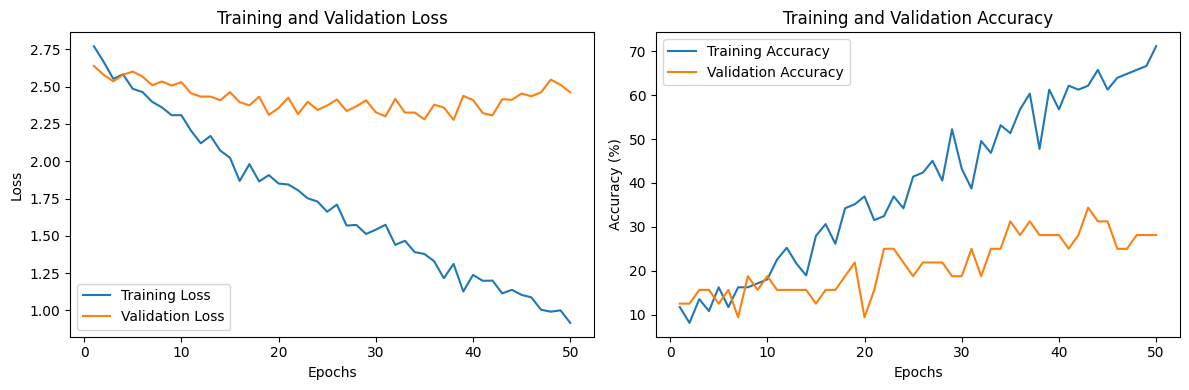

In [29]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()